In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set directories for the dataset
train_dir = '/content/drive/My Drive/Colab Notebooks/datasets/train/train'
test_dir = '/content/drive/My Drive/Colab Notebooks/datasets/test/test'

In [ ]:
# Image dimensions and batch size
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32

In [ ]:
# Image Data Generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Data generators for training and testing
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2187 images belonging to 7 classes.
Found 564 images belonging to 7 classes.


In [ ]:
# Shared input layer
input_tensor = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

In [ ]:
# VGG16 Model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
vgg16_out = GlobalAveragePooling2D()(vgg16_base.output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ResNet50 Model
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet50_out = GlobalAveragePooling2D()(resnet50_base.output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Concatenate outputs from both models
combined_out = Concatenate()([vgg16_out, resnet50_out])

In [ ]:
# Fully connected layers
x = Dense(1024, activation='relu')(combined_out)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

In [ ]:
# Output layer with softmax for multiclass classification
output_layer = Dense(train_data.num_classes, activation='softmax')(x)

In [ ]:
# Model definition
hybrid_model = Model(inputs=input_tensor, outputs=output_layer)

In [ ]:
# Freezing some layers in the base models
for layer in vgg16_base.layers[:15]:
    layer.trainable = False

for layer in resnet50_base.layers[:15]:
    layer.trainable = False

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=1e-5)  # Reduced learning rate
hybrid_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Model summary
hybrid_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 41,453,255 (158.13 MB)

 Trainable params: 33,680,647 (128.48 MB)

 Non-trainable params: 7,772,608 (29.65 MB)

In [ ]:
pip install keras

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='hybrid_best_weights.keras', save_best_only=True, verbose=1, monitor='val_accuracy', mode='max') # Monitor val_accuracy
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1) # Reduce learning rate on plateau

In [ ]:
# Train the model
hybrid_history = hybrid_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    epochs=30,  # Increased epochs
    validation_data=test_data,
    validation_steps=test_data.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1690 - loss: 2.2681 
Epoch 1: val_accuracy improved from -inf to 0.21324, saving model to hybrid_best_weights.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 1062s 13s/step - accuracy: 0.1694 - loss: 2.2662 - val_accuracy: 0.2132 - val_loss: 1.8447 - learning_rate: 1.0000e-05
Epoch 2/30
 1/68 ━━━━━━━━━━━━━━━━━━━━ 36:53 33s/step - accuracy: 0.1818 - loss: 2.3846

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.21324
68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 217ms/step - accuracy: 0.1818 - loss: 2.3846 - val_accuracy: 0.0000e+00 - val_loss: 2.3751 - learning_rate: 1.0000e-05
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.2887 - loss: 1.8348
Epoch 3: val_accuracy improved from 0.21324 to 0.29044, saving model to hybrid_best_weights.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 722ms/step - accuracy: 0.2893 - loss: 1.8337 - val_accuracy: 0.2904 - val_loss: 1.7969 - learning_rate: 1.0000e-05
Epoch 4/30
 1/68 ━━━━━━━━━━━━━━━━━━━━ 31s 465ms/step - accuracy: 0.4375 - loss: 1.6312
Epoch 4: val_accuracy did not improve from 0.29044
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4375 - loss: 1.6312 - val_accuracy: 0.0000e+00 - val_loss: 2.1395 - learning_rate: 1.0000e-05
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.4199 - loss: 1.5535
Epoch 5: val_accuracy did not improve from 0.29044
68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 652ms/step - ac

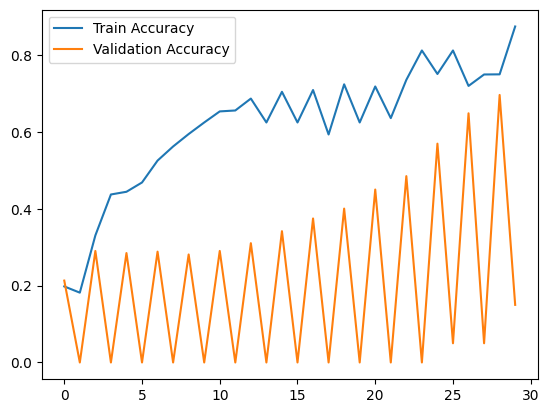

In [ ]:
# Plot training and validation accuracy
plt.plot(hybrid_history.history['accuracy'], label='Train Accuracy')
plt.plot(hybrid_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

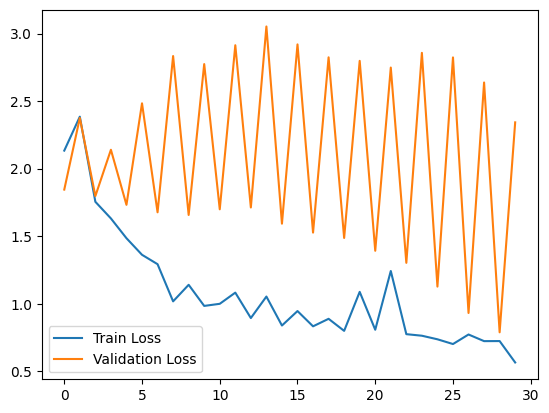

In [ ]:
# Plot training and validation loss
plt.plot(hybrid_history.history['loss'], label='Train Loss')
plt.plot(hybrid_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
loss, accuracy = hybrid_model.evaluate(test_data, steps=test_data.samples // BATCH_SIZE)

# Print the test loss and accuracy
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.6826 - loss: 0.7950
Test Loss: 0.7883, Test Accuracy: 0.6967


In [ ]:
### Saving and Downloading the Model ###

In [ ]:
# 1. Save and Download HYBRID Model in .h5 Format
from google.colab import files
hybrid_model.save('hybrid_model.h5')
files.download('hybrid_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 2. Save and Download VGG16 Model in .keras Format
hybrid_model.save('hybrid_model.keras')
files.download('hybrid_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

In [ ]:
# Load the saved model (update path to your model file)
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/hybrid_model.h5', compile=False)

In [ ]:
# Load and preprocess the image (update path to your image file)
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/datasets/test/test/cardboard/cardboard108.jpg', target_size=(224, 224))  # Ensure target size matches your model input
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the image as done during training

In [ ]:
# Predict the class of the image
pred = model.predict(x)
pred_class = np.argmax(pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
# Class labels (update based on your training classes)
index = ['cardboard','compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
# Get the predicted class
result = str(index[pred_class[0]])
print(f'Predicted Class: {result}')

Predicted Class: cardboard
